In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [142]:
cabbage_df = pd.read_csv("data-files/merged_df_1.csv")

In [143]:
cabbage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20591 entries, 0 to 20590
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DATE            20591 non-null  object 
 1   거래단위            20591 non-null  object 
 2   도매시장            20591 non-null  object 
 3   산지-광역시도         20591 non-null  object 
 4   등급              20591 non-null  object 
 5   단위_무게(kg)       20591 non-null  int64  
 6   1kg_물량          20591 non-null  int64  
 7   1kg_평균가격        20591 non-null  float64
 8   weighted_price  20591 non-null  float64
 9   광역시도            20591 non-null  object 
 10  평균기온            20591 non-null  float64
 11  평균풍속            20591 non-null  float64
 12  평균강수량           20591 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 2.0+ MB


# 데이터 부족한 도매시장제거

In [144]:
cabbage_df['DATE'] = pd.to_datetime(cabbage_df['DATE'])

# Month 열을 추가하여 날짜에서 월 정보 확인
cabbage_df['Month'] = cabbage_df['DATE'].dt.month

# 각 도매시장별 월별 데이터 개수를 확인
monthly_data_availability = cabbage_df.groupby(['도매시장', 'Month']).size().unstack(fill_value=0)

# 모든 월(1월~12월)에 데이터가 존재하는 도매시장만 필터링
sufficient_data_markets = monthly_data_availability[monthly_data_availability.min(axis=1) > 0].index

# 충분한 데이터를 가진 도매시장만 포함
filtered_cabbage_df = cabbage_df[cabbage_df['도매시장'].isin(sufficient_data_markets)]


# 충분한 데이터를 가진 도매시장 수와 총 데이터 개수 확인
market_counts = filtered_cabbage_df['도매시장'].value_counts()
total_data_count = len(filtered_cabbage_df)

# 결과 출력
{
    "Total Markets After Filtering": len(sufficient_data_markets),  # 제거 후 남은 도매시장 수
    "Total Data Count After Filtering": total_data_count            # 필터링 후 총 데이터 개수
}


{'Total Markets After Filtering': 30,
 'Total Data Count After Filtering': 20580}

# 신뢰구간으로 이상치 제거

In [145]:
# 80% 신뢰구간 (하위 10%, 상위 90%) 경계 계산
lower_bound = filtered_cabbage_df['1kg_평균가격'].quantile(0.10)
upper_bound = filtered_cabbage_df['1kg_평균가격'].quantile(0.90)

# 80% 신뢰구간 내의 데이터만 필터링
confidence_filtered_data_80 = filtered_cabbage_df[
    (filtered_cabbage_df['1kg_평균가격'] >= lower_bound) & 
    (filtered_cabbage_df['1kg_평균가격'] <= upper_bound)
]

# 90% 신뢰구간 (하위 5%, 상위 95%) 경계 계산
lower_bound_90 = filtered_cabbage_df['1kg_평균가격'].quantile(0.05)
upper_bound_90 = filtered_cabbage_df['1kg_평균가격'].quantile(0.95)

# 90% 신뢰구간 내의 데이터만 필터링
confidence_filtered_data_90 = filtered_cabbage_df[
    (filtered_cabbage_df['1kg_평균가격'] >= lower_bound_90) & 
    (filtered_cabbage_df['1kg_평균가격'] <= upper_bound_90)
]



In [146]:
# filtered_cabbage_df.to_csv("data-files/filtered_cabbage_df.csv", index=False)

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# 재배 유형 정의
cultivation_periods = {
    "봄재배": {"planting": [3, 4, 5, 6], "harvesting": [6, 7]},
    "가을재배": {"planting": [8, 9, 10], "harvesting": [10, 11]},
    "월동재배": {"planting": [10, 11], "harvesting": [3, 4, 5]},
    "여름재배": {"planting": [6, 7, 8], "harvesting": [9, 10]}
}

# 각 재배 유형에 대해 파종 및 수확 여부를 나타내는 열 추가
for cultivation, periods in cultivation_periods.items():
    confidence_filtered_data_80[cultivation] = (
        confidence_filtered_data_80['Month'].isin(periods['planting'] + periods['harvesting'])
    ).astype(int)

# '도매시장' 열 원-핫 인코딩 수행
filtered_data_80 = pd.get_dummies(confidence_filtered_data_80, columns=['도매시장'], prefix='Market')

# 피처(feature)와 타겟(target) 선택
features = [
    '1kg_물량', '평균기온', '평균풍속', '평균강수량'
] + list(cultivation_periods.keys()) + [col for col in filtered_data_80.columns if col.startswith('Market_')]
X = filtered_data_80[features]
y = filtered_data_80['1kg_평균가격']

# 결측값 처리: 결측값이 포함된 행 제거
X = X.dropna()
y = y.loc[X.index]

# 피처 스케일링: 데이터 정규화를 위해 StandardScaler 사용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터를 학습용(80%)과 테스트용(20%)으로 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)



C:\Users\human\AppData\Local\Temp\ipykernel_7648\2016825129.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confidence_filtered_data_80[cultivation] = (
C:\Users\human\AppData\Local\Temp\ipykernel_7648\2016825129.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  confidence_filtered_data_80[cultivation] = (
C:\Users\human\AppData\Local\Temp\ipykernel_7648\2016825129.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

# 랜덤 포레스트

In [148]:
# 랜덤 포레스트 모델 초기화 및 학습
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# 테스트 데이터로 예측 수행
y_pred = rf_model.predict(X_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 평가 결과 출력
mae, mse, rmse, r2

(np.float64(129.8340128903395),
 np.float64(28667.15072789447),
 np.float64(169.3137641418868),
 0.3915404993946303)

In [149]:
target_mean = y.mean()

mae_ratio = mae / target_mean

target_mean, mae_ratio

(np.float64(639.6492956891403), np.float64(0.20297687149090024))

# XGBoost

In [150]:
from xgboost import XGBRegressor

# 랜덤 포레스트 모델 초기화 및 학습
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

# 테스트 데이터로 예측 수행
y_pred = xgb_model.predict(X_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 평가 결과 출력
mae, mse, rmse, r2

(np.float64(130.9840330954913),
 np.float64(28201.557043923094),
 np.float64(167.93319220429026),
 0.4014227127726965)

# 로그

In [151]:
# 1차: 월별, 도매시장별, 산지-광역시도별로 IQR을 이용한 이상치 제거
def remove_outliers_iqr(group, column):
    Q1 = group[column].quantile(0.25)
    Q3 = group[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group[column] >= lower_bound) & (group[column] <= upper_bound)]

# 그룹화하여 1차 이상치 제거
filtered_cabbage_df_no_outliers_1 = filtered_cabbage_df.groupby(['Month', '도매시장', '산지-광역시도'], group_keys=False).apply(remove_outliers_iqr, column='1kg_평균가격')

# 2차: 로그 변환 적용 후 이상치 제거
filtered_cabbage_df_no_outliers_1['log_1kg_평균가격'] = np.log1p(filtered_cabbage_df_no_outliers_1['1kg_평균가격'])  # 로그 변환

filtered_cabbage_df_log = filtered_cabbage_df_no_outliers_1.groupby(['Month', '도매시장', '산지-광역시도'], group_keys=False).apply(remove_outliers_iqr, column='log_1kg_평균가격')



C:\Users\human\AppData\Local\Temp\ipykernel_7648\3434969813.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_cabbage_df_no_outliers_1 = filtered_cabbage_df.groupby(['Month', '도매시장', '산지-광역시도'], group_keys=False).apply(remove_outliers_iqr, column='1kg_평균가격')
C:\Users\human\AppData\Local\Temp\ipykernel_7648\3434969813.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_cabbage_df_log = 

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 재배 유형 정의
cultivation_periods = {
    "봄재배": {"planting": [3, 4, 5, 6], "harvesting": [6, 7]},
    "가을재배": {"planting": [9, 10], "harvesting": [10, 11]},
    "월동재배": {"planting": [9, 10, 11], "harvesting": [3, 4, 5]},
    "여름재배": {"planting": [6, 7, 8], "harvesting": [9, 10]}
}

# 각 재배 유형에 대해 파종 및 수확 여부를 나타내는 열 추가
for cultivation, periods in cultivation_periods.items():
    filtered_cabbage_df_log[cultivation] = (
        filtered_cabbage_df_log['Month'].isin(periods['planting'] + periods['harvesting'])
    ).astype(int)

# '도매시장' 열 원-핫 인코딩 수행
filtered_data_80 = pd.get_dummies(filtered_cabbage_df_log, columns=['도매시장'], prefix='Market')

# 피처(feature)와 타겟(target) 선택
features = [
    '1kg_물량', '평균기온', '평균풍속', '평균강수량'
] + list(cultivation_periods.keys()) + [col for col in filtered_data_80.columns if col.startswith('Market_')]
X = filtered_data_80[features]
y = filtered_data_80['1kg_평균가격']

# 결측값 처리: 결측값이 포함된 행 제거
X = X.dropna()
y = y.loc[X.index]

# 피처 스케일링: 데이터 정규화를 위해 StandardScaler 사용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 데이터를 학습용(80%)과 테스트용(20%)으로 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [153]:
# 랜덤 포레스트 모델 초기화 및 학습
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# 테스트 데이터로 예측 수행
y_pred = rf_model.predict(X_test)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# 평가 결과 출력
mae, mse, rmse, r2

(np.float64(170.97903660002737),
 np.float64(65113.221925301885),
 np.float64(255.17292553345445),
 0.5232280694588152)

# 1 진행중

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [165]:
data = pd.read_csv("data-files/filtered_90_percent_confidence.csv")

data['Year'] = pd.to_datetime(data['DATE']).dt.year

# get_dummies

In [169]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

cultivation_seasons = {
    '봄재배': {'파종기': [3, 4], '정식기': [4, 5], '수확기': [7, 8]},
    '가을재배': {'파종기': [7], '정식기': [8], '수확기': [10, 11]},
    '월동재배': {'파종기': [9], '정식기': [10], '수확기': [3, 4, 5]},
    '여름재배': {'파종기': [5, 6], '정식기': [6, 7], '수확기': [9]}
}

# 결과 저장을 위한 데이터프레임 초기화
model_data = pd.DataFrame()

# 재배 방식 정보를 1 또는 0으로 표시
for season, periods in cultivation_seasons.items():
    # 입력 데이터 생성 (파종기 및 정식기)
    input_data = data[data['Month'].isin(periods['파종기'] + periods['정식기'])].copy()
    input_data[f'{season}_여부'] = 1  # 해당 재배 방식 여부를 1로 표시
    
    # 나머지 데이터에 대해서는 0으로 설정
    input_data = data.assign(**{f'{season}_여부': data['Month'].apply(
        lambda x: 1 if x in (periods['파종기'] + periods['정식기']) else 0)})

    # 타겟 데이터 생성 (수확기)
    target_data = data[data['Month'].isin(periods['수확기'])]
    target_values = target_data.groupby(['Year', '도매시장', '산지-광역시도'])['1kg_평균가격'].mean().reset_index()
    target_values.rename(columns={'1kg_평균가격': '타겟값'}, inplace=True)
    
    # 입력 데이터와 타겟 데이터 병합
    season_data = pd.merge(input_data, target_values, on=['Year', '도매시장', '산지-광역시도'], how='inner')
    model_data = pd.concat([model_data, season_data], ignore_index=True)


# 입력 변수(X)와 타겟값(y) 분리
X = model_data[['평균기온', '평균풍속', '평균강수량', '봄재배_여부', '여름재배_여부', '가을재배_여부', '월동재배_여부','도매시장','산지-광역시도']]
y = model_data['타겟값']

# 범주형 데이터 (도매시장, 산지-광역시도)에 대해 원-핫 인코딩
X = pd.get_dummies(X, columns=['도매시장', '산지-광역시도'], drop_first=True)

# 모델 생성 및 성능 평가
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# 결과 저장 및 표시
performance_metrics = {
    "MAE": mae,
    "RMSE": rmse,
    "R-squared": r2
}

performance_metrics

c:\Users\human\anaconda3\envs\human-da-env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': np.float64(45.31967558998742),
 'RMSE': np.float64(86.44003903983291),
 'R-squared': 0.825191363641721}

# 원-핫

In [164]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15947 entries, 2021-01-01 to 2021-12-01
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   거래단위            15947 non-null  object 
 1   도매시장            15947 non-null  object 
 2   산지-광역시도         15947 non-null  object 
 3   등급              15947 non-null  object 
 4   단위_무게(kg)       15947 non-null  int64  
 5   1kg_물량          15947 non-null  int64  
 6   1kg_평균가격        15947 non-null  float64
 7   weighted_price  15947 non-null  float64
 8   광역시도            15947 non-null  object 
 9   평균기온            15947 non-null  float64
 10  평균풍속            15947 non-null  float64
 11  평균강수량           15947 non-null  float64
 12  Month           15947 non-null  int64  
 13  z_score         15947 non-null  float64
dtypes: float64(6), int64(3), object(5)
memory usage: 1.8+ MB


In [166]:
# 결과 저장을 위한 데이터프레임 초기화
model_data = pd.DataFrame()

cultivation_seasons = {
    '봄재배': {'파종기': [3, 4], '정식기': [4, 5], '수확기': [7, 8]},
    '가을재배': {'파종기': [7], '정식기': [8], '수확기': [10, 11]},
    '월동재배': {'파종기': [9], '정식기': [10], '수확기': [3, 4, 5]},
    '여름재배': {'파종기': [5, 6], '정식기': [6, 7], '수확기': [9]}
}

# 재배 방식 정보를 추가 (월동재배의 수확기 연도 조정 포함)
for season, periods in cultivation_seasons.items():
    # 입력 데이터 생성 (파종기 및 정식기)
    input_data = data[data['Month'].isin(periods['파종기'] + periods['정식기'])].copy()
    input_data['재배방식'] = season  # 해당 재배 방식 추가
    
    # 타겟 데이터 생성 (수확기)
    target_data = data[data['Month'].isin(periods['수확기'])].copy()
    
    # 월동재배의 수확기 연도 조정
    if season == '월동재배':
        target_data['Year'] += 1  # 수확기는 다음 연도로 설정
    
    # 타겟값 계산
    target_values = target_data.groupby(['Year', '도매시장', '산지-광역시도'])['1kg_평균가격'].mean().reset_index()
    target_values.rename(columns={'1kg_평균가격': '타겟값'}, inplace=True)
    
    # 입력 데이터와 타겟 데이터 병합
    season_data = pd.merge(input_data, target_values, on=['Year', '도매시장', '산지-광역시도'], how='inner')
    model_data = pd.concat([model_data, season_data], ignore_index=True)

duplicate_check = model_data.duplicated(subset=['Year', 'Month', '도매시장', '산지-광역시도'])
print("중복 여부 확인:", duplicate_check.any())

# 중복 데이터 제거 (필요 시)
model_data = model_data.drop_duplicates(subset=['Year', 'Month', '도매시장', '산지-광역시도'])

# 입력 변수(X)와 타겟값(y) 분리
X = model_data[['평균기온', '평균풍속', '평균강수량', '재배방식', '도매시장', '산지-광역시도']]
y = model_data['타겟값']


# 재배 방식에 대해 원-핫 인코딩 (3개의 열 생성)
X = pd.get_dummies(X, columns=['재배방식', '도매시장', '산지-광역시도'], drop_first=True)

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
model = RandomForestRegressor(random_state=42, n_estimators=100)
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# 결과 저장 및 표시
performance_metrics = {
    "MAE": mae,
    "RMSE": rmse,
    "R-squared": r2
}

performance_metrics

중복 여부 확인: True


c:\Users\human\anaconda3\envs\human-da-env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


{'MAE': np.float64(121.6131713088262),
 'RMSE': np.float64(162.32532751094973),
 'R-squared': 0.42970635447907235}

# 시계열 모델 SARIMA

# 정상성 확인

In [158]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 데이터 불러오기
data = pd.read_csv('D:/humanda/pjt-02/Mook/data-files/filtered_80_percent_confidence.csv')

# 1. 데이터 준비
# 날짜 열을 시계열 인덱스로 변환
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)

# 월별 평균값 계산 (1kg 평균가격)
price_series = data['1kg_평균가격'].resample('M').mean()

# 2. 정상성 확인 (ADF 테스트)
adf_test = adfuller(price_series.dropna())
if adf_test[1] < 0.05:
    print("데이터는 정상성을 만족합니다.")
else:
    print("데이터는 정상성을 만족하지 않습니다. 차분이 필요합니다.")


데이터는 정상성을 만족합니다.


C:\Users\human\AppData\Local\Temp\ipykernel_7648\2778426093.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  price_series = data['1kg_평균가격'].resample('M').mean()


# SARIMA 모델 학습 및 평가

In [159]:
# 3. SARIMA 모델 학습
# SARIMA 모델 설정 및 학습 (p, d, q = 1, 1, 1 / P, D, Q, S = 1, 1, 1, 12)
model = SARIMAX(price_series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_result = model.fit(disp=False)

# 4. 예측 생성
forecast_steps = 12  # 12개월 예측
forecast = sarima_result.get_forecast(steps=forecast_steps)

# 예측값과 신뢰 구간
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# 5. 모델 평가
# 훈련 데이터에 대한 예측값 생성
train_pred = sarima_result.fittedvalues

# 평가 지표 계산
mae = mean_absolute_error(price_series.dropna(), train_pred)
rmse = mean_squared_error(price_series.dropna(), train_pred, squared=False)
mape = (np.abs((price_series.dropna() - train_pred) / price_series.dropna()) * 100).mean()

# 평가 결과 출력
evaluation_results = {
    "MAE": mae,
    "RMSE": rmse,
    "MAPE (%)": mape
}
print("SARIMA 모델 평가 결과:", evaluation_results)

c:\Users\human\anaconda3\envs\human-da-env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


SARIMA 모델 평가 결과: {'MAE': np.float64(122.99652667593595), 'RMSE': np.float64(167.65297722676146), 'MAPE (%)': np.float64(20.398846038778903)}


c:\Users\human\anaconda3\envs\human-da-env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


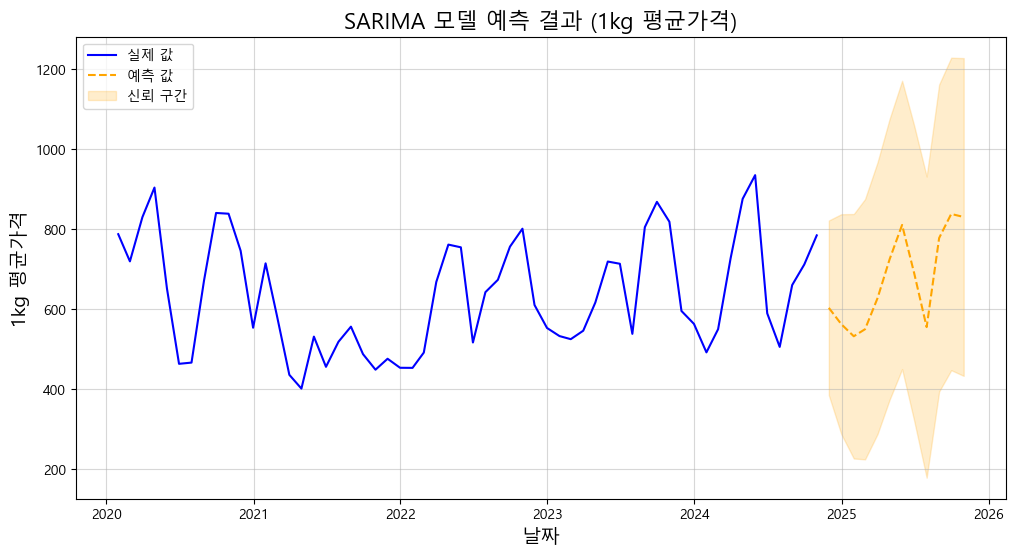

In [160]:
#한글
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# 6. 시각화
plt.figure(figsize=(12, 6))
plt.plot(price_series, label='실제 값', color='blue')  # 실제값
plt.plot(forecast_values.index, forecast_values, label='예측 값', color='orange', linestyle='--')  # 예측값
plt.fill_between(forecast_values.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='orange', alpha=0.2, label='신뢰 구간')  # 신뢰 구간
plt.title('SARIMA 모델 예측 결과 (1kg 평균가격)', fontsize=16)
plt.xlabel('날짜', fontsize=14)
plt.ylabel('1kg 평균가격', fontsize=14)
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# ETS 모델

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 1. ETS 모델 학습
# 계절성(12개월), 추세, 그리고 데이터 수준을 고려
ets_model = ExponentialSmoothing(price_series, trend="add", seasonal="add", seasonal_periods=12)
ets_result = ets_model.fit()

# 2. 예측 생성 (향후 12개월)
ets_forecast = ets_result.forecast(steps=12)

# 3. 모델 평가 (훈련 데이터 내)
ets_train_pred = ets_result.fittedvalues

# 평가 지표 계산
ets_mae = mean_absolute_error(price_series.dropna(), ets_train_pred)
ets_rmse = mean_squared_error(price_series.dropna(), ets_train_pred, squared=False)
ets_mape = (np.abs((price_series.dropna() - ets_train_pred) / price_series.dropna()) * 100).mean()

# 평가 결과
ets_evaluation_results = {
    "MAE": ets_mae,
    "RMSE": ets_rmse,
    "MAPE (%)": ets_mape
}

print("ETS 모델 평가 결과:", ets_evaluation_results)

c:\Users\human\anaconda3\envs\human-da-env\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


NameError: name 'ets_test_pred' is not defined

# SARIMA, ETS 결과 비교

In [162]:
# SARIMA 결과와 ETS 결과 비교
comparison_results = {
    "SARIMA": evaluation_results,
    "ETS": ets_evaluation_results
}

comparison_results

{'SARIMA': {'MAE': np.float64(122.99652667593595),
  'RMSE': np.float64(167.65297722676146),
  'MAPE (%)': np.float64(20.398846038778903)},
 'ETS': {'MAE': np.float64(77.66668570077782),
  'RMSE': np.float64(95.98926932000644),
  'MAPE (%)': np.float64(13.210717805292097)}}

# 분류 모델

In [176]:
seasons = {
    'Spring_6': [3, 4, 5],
    'Spring_7': [4, 5, 6],
    'Summer_9': [6, 7, 8],
    'Summer_8': [5, 6, 7],
    'Autumn_10': [7, 8, 9],
    'Autumn_11': [8, 9, 10],
    'Winter_3': [9, 10, 11],
    'Winter_4': [10, 11, 12],
}

# Initialize columns for each season and month combination
for season in seasons:
    data[season] = data['Month'].apply(lambda x: 1 if x in seasons[season] else 0)

# Remove rows for January and February as they are not part of any harvest period
filtered_data = data[~data['Month'].isin([1, 2])]


In [ ]:
# Calculate target average price for each harvest season based on the specified logic
harvest_targets = {
    'Spring_6': [6],
    'Spring_7': [7],
    'Summer_9': [9],
    'Summer_8': [8],
    'Autumn_10': [10],
    'Autumn_11': [11],
    'Winter_3': [3],
    'Winter_4': [4],
}

# 그룹화하여 수확기별 평균 금액을 계산
group_columns = ['도매시장', '산지-광역시도', 'Month']

# 각 월별 평균 금액을 도매시장과 산지-광역시도별로 계산
filtered_data['Harvest_Target'] = filtered_data.groupby(group_columns)['1kg_평균가격'].transform('mean')



C:\Users\human\AppData\Local\Temp\ipykernel_7648\3048162134.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Harvest_Target'] = filtered_data.apply(


In [178]:
filtered_data

,DATE,거래단위,도매시장,산지-광역시도,등급,단위_무게(kg),1kg_물량,1kg_평균가격,weighted_price,광역시도,평균기온,평균풍속,평균강수량,Month,z_score,Year,Spring_6,Spring_7,Summer_9,Summer_8,Autumn_10,Autumn_11,Winter_3,Winter_4,Harvest_Target
2390,2024-03-01,8kg그물망,강릉도매시장,경기도,특,8,512,1304.687500,668000.0,경기도,5.65,1.78,31.80,3,1.749984,2024,1,0,0,0,0,0,0,0,1304.687500
2391,2024-03-01,8kg파렛트,강릉도매시장,경기도,특,8,5184,969.907407,5028000.0,경기도,5.65,1.78,31.80,3,0.821994,2024,1,0,0,0,0,0,0,0,969.907407
2392,2024-03-01,8kg그물망,강릉도매시장,경상북도,특,8,320,1250.000000,400000.0,경상북도,6.33,2.10,68.05,3,1.598393,2024,1,0,0,0,0,0,0,0,1250.000000
2393,2021-03-01,8kg그물망,강릉도매시장,부산광역시,특,8,11520,469.444444,5408000.0,부산광역시,10.69,2.61,154.08,3,-0.565260,2021,1,0,0,0,0,0,0,0,469.444444
2394,2021-03-01,10kg그물망,강릉도매시장,부산광역시,특,10,176600,514.603624,90879000.0,부산광역시,10.69,2.61,154.08,3,-0.440081,2021,1,0,0,0,0,0,0,0,514.603624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17869,2022-12-01,11kg그물망,포항도매시장,제주도,특,11,42471,652.558923,27714830.0,제주도,4.16,4.26,44.25,12,-0.057677,2022,0,0,0,0,0,0,0,1,NaN
17870,2021-12-01,11kg그물망,포항도매시장,제주도,특,11,20207,435.274905,8795600.0,제주도,5.82,4.06,39.87,12,-0.659975,2021,0,0,0,0,0,0,0,1,NaN
17871,2023-12-01,12kg그물망,포항도매시장,제주도,특,12,102240,402.420188,41143440.0,제주도,6.69,3.83,123.52,12,-0.751047,2023,0,0,0,0,0,0,0,1,NaN
17872,2022-12-01,12kg그물망,포항도매시장,제주도,특,12,36288,500.330688,18156000.0,제주도,4.16,4.26,44.25,12,-0.479645,2022,0,0,0,0,0,0,0,1,NaN


# 타겟값에 중복 확인

In [180]:
# Harvest_Target의 고유 값 개수와 분포 확인
unique_target_values = filtered_data['Harvest_Target'].nunique()
target_value_counts = filtered_data['Harvest_Target'].value_counts()

target_value_counts

Harvest_Target
500.000000     200
400.000000     129
600.000000     111
300.000000     107
1000.000000     99
              ... 
356.774194       1
707.727273       1
702.408027       1
262.769231       1
1015.148628      1
Name: count, Length: 9930, dtype: int64